In [1]:
#This script is used for drought analyses
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from scipy import stats

C:\Users\jiang\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#grid 1 DEG
y1d=np.arange(70,-60.1,-1)
x1d=np.arange(-170,180.1,1)
lon1s,lat1s=np.meshgrid(x1d, y1d)
#2 deg, cropland mask
imai0=np.load('/change to your path/imai0_full.npy',allow_pickle=True)
y3d=np.arange(70,-60.1,-2.)
x3d=np.arange(-170,180.1,2.)
lon3s,lat3s=np.meshgrid(x3d, y3d)

imai_2degf=np.zeros((66,176))*np.nan
for y in range(66):
    for x in range(176):
        al=[imai0[0,y,x],imai0[1,y,x],imai0[2,y,x],imai0[3,y,x],imai0[4,y,x]]
        if np.count_nonzero(np.array(al)>0)>0:
            imai_2degf[y,x]=np.nanmax(al)

In [3]:
#2002-2022 NIRv datasets###############################################################
nirvf=np.load('/change to your path/nir_full_1deg.npy',allow_pickle=True)
nirvf5=np.zeros((21,73,66,176))*np.nan
for yr in range(21):
    for pdt in range(73):
        nirvf5[yr,pdt,:,:] = griddata((lon1s[0:130,0:350].ravel(),lat1s[0:130,0:350].ravel()), nirvf[yr,pdt,::-1,:].ravel(),(lon3s, lat3s) , method='nearest')   
#get rid of non crop & -1 grids
crop_m3=np.where(imai_2degf<2)
nirvf_m5=np.ones((21,73,66,176))*np.nan
for yr in range(21):
    for pdt in range(73):
        mk4=np.where(nirvf5[yr,pdt,:,:]<0)
        i3=nirvf5[yr,pdt,:,:]
        i3[mk4]=np.nan
        i3[crop_m3]=np.nan
        nirvf_m5[yr,pdt,:,:]=i3

In [4]:
#crop calendar data mask
wcu=xr.open_dataset('/change to your path/Wheat.crop.calendar.nc')
loncs,latcs=np.meshgrid(wcu.longitude[19::], wcu.latitude[39:300])#GCE
long,latg=np.meshgrid(wcu.longitude, wcu.latitude)#CCD
imog_nacf=np.load('/change to your path/cecl_gs_0.5_v3.npy',allow_pickle=True)     
#2deg
y1d=np.arange(70,-60.1,-2)
x1d=np.arange(-170,180.1,2)
lon2s,lat2s=np.meshgrid(x1d, y1d)
imog_nac2=np.zeros((2,66,176))*np.nan
imog_nac2[0,:,:] = griddata((loncs.ravel(),latcs.ravel()), imog_nacf[0,:,:].ravel(),(lon2s, lat2s) , method='nearest')   
imog_nac2[1,:,:] = griddata((loncs.ravel(),latcs.ravel()), imog_nacf[1,:,:].ravel(),(lon2s, lat2s) , method='nearest')   

In [5]:
#grow season
nirvf_mean=np.zeros((66,176))*np.nan
for y in range(66):
    for x in range(176):
        sog_na=imog_nac2[0,y,x]
        eog_na=imog_nac2[1,y,x]
        if np.isnan(sog_na)==False and np.isnan(eog_na)==False and imai_2degf[y,x]>=2:
            sogr_na=int(round(sog_na)/5.)#if %5==0, then need to -1
            eogr_na=int(round(eog_na)/5.)
            if sogr_na%5==0:
                sogr_na=sogr_na-1
            if eogr_na%5==0:
                eogr_na=eogr_na-1
            if sogr_na<eogr_na:
                nirl=np.nanmean(nirvf_m5[1:18,sogr_na:eogr_na+1,y,x],axis=0)
                nirvf_mean[y,x]=np.nanmean(nirl)
            if sogr_na>eogr_na:
                nirli=np.append(nirvf_m5[1:18,sogr_na::,y,x],nirvf_m5[2:19,0:eogr_na+1,y,x],axis=1)
                nirl=np.nanmean(nirli,axis=0)
                nirvf_mean[y,x]=np.nanmean(nirl)

C:\Users\jiang\AppData\Local\Temp\ipykernel_29288\2540320667.py:15: RuntimeWarning: Mean of empty slice
  nirl=np.nanmean(nirvf_m5[1:18,sogr_na:eogr_na+1,y,x],axis=0)
C:\Users\jiang\AppData\Local\Temp\ipykernel_29288\2540320667.py:16: RuntimeWarning: Mean of empty slice
  nirvf_mean[y,x]=np.nanmean(nirl)
C:\Users\jiang\AppData\Local\Temp\ipykernel_29288\2540320667.py:19: RuntimeWarning: Mean of empty slice
  nirl=np.nanmean(nirli,axis=0)
C:\Users\jiang\AppData\Local\Temp\ipykernel_29288\2540320667.py:20: RuntimeWarning: Mean of empty slice
  nirvf_mean[y,x]=np.nanmean(nirl)


In [6]:
#beck model based phenology:
#saved phase data
glos_rfs2=np.load('/change to your path/glos_rfs5.npy',allow_pickle=True)#greenup
glos_veg2=np.load('/change to your path/glos_veg5.npy',allow_pickle=True)#end of vegetative
glos_rep2=np.load('/change to your path/glos_rep5.npy',allow_pickle=True)#end of reproductive
glos_rfe2=np.load('C/change to your path/glos_rfe5.npy',allow_pickle=True)#harves

In [7]:
#read in evaporative stress index (ESI)
esi_f=np.load('/change to your path/esi_0319.npy',allow_pickle=True)
#align with crop and interpolate
mk1=np.where(esi_f==-99)
esi_f[mk1]=np.nan
esi_c=np.zeros((17,52,65,175))*np.nan
for y in range(65):
    for x in range(175):
        sog_na=imog_nac2[0,y,x]
        eog_na=imog_nac2[1,y,x]
        if np.isnan(sog_na)==False and np.isnan(eog_na)==False and imai_2degf[y,x]>=2:
            esi_c[:,:,y,x]=esi_f[:,:,y,x]

In [8]:
#consider a year with agricultural drought
def count_consecutive_drought(drought_array):
    max_consecutive = 0          # Variable to store the maximum number of consecutive drought periods
    current_consecutive = 0      # Variable to store the count of the current consecutive drought periods
    for drought in drought_array:  # Loop over each element (True/False) in the drought_array
        if drought:  # If the current element is True (i.e., drought condition is met)
            current_consecutive += 1  # Increment the current consecutive drought counter
            max_consecutive = max(max_consecutive, current_consecutive)  # Update max consecutive if necessary
        else:  # If the current element is False (i.e., no drought)
            current_consecutive = 0  # Reset the current consecutive counter to 0
    return max_consecutive  # Return the maximum number of consecutive drought periods

In [9]:
esi_a1=np.zeros((16,65,175))*np.nan
for y in range(65):
    for x in range(175):
        if np.isnan(glos_rfs2[y,x])==False and np.isnan(glos_rep2[y,x])==False and imai_2degf[y,x]>=2 and np.isnan(nirvf_mean[y,x])==False:
            d1=int(round(glos_rfs2[y,x]*5/7))
            if round(glos_rfs2[y,x]*5)%7==0:
                d1=d1-1
            d2=int(round(glos_rep2[y,x]*5/7))
            if round(glos_rep2[y,x]*5)%7==0:
                d2=d2-1
            for yr in range(16):
                eli=esi_c[yr,:,y,x]
                if np.count_nonzero(np.isnan(eli))!=52:
                    if d1<d2 and d1>0:
                        eli2=eli[d1:d2+1]
                    if d1<0:
                        eli2=np.append(esi_c[yr-1,51+d1:52,y,x],eli[0:d2])
                    if d1>d2:
                        eli2=np.append(eli[d1:52],esi_c[yr+1,0:d2+1,y,x])
                    dr = eli2 < -0.5 #moderate drought
                    esi_a1[yr,y,x]=count_consecutive_drought(dr)

In [10]:
#identify a drought following the Methods section
def count_consecutive_drought(esi_array, drought_threshold=-0.5, esi_threshold=-0.5):
    max_consecutive = 0         # Variable to store the maximum number of consecutive drought periods
    current_consecutive = 0     # Variable to store the count of the current consecutive drought periods
    non_drought_days = 0        # Counter for the number of non-drought days
    max_consecutive_start_idx = None  # Variable to store the start index of the maximum consecutive drought period
    max_consecutive_end_idx = None    # Variable to store the end index of the maximum consecutive drought period
    current_start_idx = None    # Start index of the current drought period
    esi_sum = 0                 # To calculate the cumulative ESI during the drought event (only for values below threshold)
    esi_mean = 0                # To calculate the mean ESI during the drought event
    
    # Track the number of ESI values used for calculating the mean ESI
    esi_count = 0

    for i, esi_value in enumerate(esi_array):
        if esi_value < drought_threshold:  # Drought condition based on ESI threshold
            if current_start_idx is None:
                current_start_idx = i  # Set the start index of the drought period

            current_consecutive += 1  # Increment the consecutive drought counter
            
            # Only include ESI values less than the specified threshold for calculating mean ESI (e.g., -1)
            if esi_value < esi_threshold:
                esi_sum += esi_value  # Add the ESI value during this period (only if below threshold)
                esi_count += 1  # Count only the ESI values below the threshold

            max_consecutive = max(max_consecutive, current_consecutive)  # Update max consecutive if necessary
            
            # If this is the new max consecutive drought period, store the start and end indices
            if max_consecutive == current_consecutive:
                max_consecutive_start_idx = current_start_idx
                max_consecutive_end_idx = i  # The end of the current drought period is the current index

        else:  # ESI > drought_threshold (non-drought day)
            # Ensure non-drought day is within the drought period, not at the start or end
            if current_start_idx is not None and i > current_start_idx and i < len(esi_array) - 1:
                if non_drought_days < 1:  # Allow 1 non-drought day, but not at the start or end
                    non_drought_days += 1  # Increment the non-drought day counter
                    current_consecutive += 1  # Still count this day as part of the drought period
                else:
                    # End the drought period because we have more than 1 non-drought day
                    if esi_count > 0:
                        esi_mean = esi_sum / esi_count  # Calculate the mean ESI only if there were valid values
                    else:
                        esi_mean = float('nan')  # No valid ESI values below threshold, set as NaN
                    
                    current_consecutive = 0
                    non_drought_days = 0
                    current_start_idx = None  # Reset the start index of the current drought period
                    esi_sum = 0  # Reset cumulative ESI for the next drought period
                    esi_count = 0  # Reset the count for the next drought period
            else:
                # If a non-drought day occurs at the start or end, end the current drought period
                if current_consecutive > 0:
                    if esi_count > 0:
                        esi_mean = esi_sum / esi_count
                    else:
                        esi_mean = float('nan')

                current_consecutive = 0
                non_drought_days = 0
                current_start_idx = None
                esi_sum = 0
                esi_count = 0

    # Final calculation of mean ESI if the drought ends at the last element
    if current_consecutive > 0:
        if esi_count > 0:
            esi_mean = esi_sum / esi_count  # Calculate mean ESI at the end of the drought
        else:
            esi_mean = float('nan')  # No valid ESI values below threshold, set as NaN

    return max_consecutive, max_consecutive_start_idx, max_consecutive_end_idx, esi_mean  # Return the results


In [11]:
#calculate the length and intensity of droughts
esi_len2=np.zeros((16,65,175))*np.nan
esi_me2=np.zeros((16,65,175))*np.nan
for y in range(65):
    for x in range(175):
        if np.isnan(glos_rfs2[y,x])==False and np.isnan(glos_rep2[y,x])==False and imai_2degf[y,x]>=2 and np.isnan(nirvf_mean[y,x])==False:
            d1=int(round(glos_rfs2[y,x]*5/7))
            if round(glos_rfs2[y,x]*5)%7==0:
                d1=d1-1
            d2=int(round(glos_rep2[y,x]*5/7))
            if round(glos_rep2[y,x]*5)%7==0:
                d2=d2-1
            for yr in range(16):
                eli=esi_c[yr,:,y,x]
                if esi_a1[yr,y,x]>=2:
                    if np.count_nonzero(np.isnan(eli))!=52:
                        if d1<d2:# and d1>5 and d2<=47
                            eli2=eli[d1:d2+1]
                        if d1>d2:
                            eli2=np.append(eli[d1:52],esi_c[yr+1,0:d2+1,y,x])
                        max_consecutive, start_idx, end_idx, esi_mean=count_consecutive_drought(eli2)
                        esi_len2[yr,y,x]=max_consecutive
                        esi_me2[yr,y,x]=esi_mean

In [12]:
#check the frequency of droughts
esi_ad1=np.zeros((65,175))*np.nan#frequency
esi_id1=np.zeros((16,65,175))*np.nan#intensity
for y in range(65):
    for x in range(175):
        if np.isnan(glos_rfs2[y,x])==False and np.isnan(glos_rep2[y,x])==False and imai_2degf[y,x]>=2 and np.isnan(nirvf_mean[y,x])==False:
            esi_ad1[y,x]=np.count_nonzero(esi_len2[:,y,x]>4)
for yr in range(16):
    for y in range(65):
        for x in range(175):
            if np.isnan(glos_rfs2[y,x])==False and np.isnan(glos_rep2[y,x])==False and imai_2degf[y,x]>=2 and np.isnan(nirvf_mean[y,x])==False and esi_len2[yr,y,x]>4 and np.isnan(esi_me2[yr,y,x])==False:
                esi_id1[yr,y,x]=esi_me2[yr,y,x]

{-180: ([<matplotlib.lines.Line2D at 0x1a9881ab040>],
  [Text(-179.64, -63.6, '180°'), Text(179.64, -63.6, '180°')]),
 -120: ([<matplotlib.lines.Line2D at 0x1a9881cb250>],
  [Text(-119.88, -63.6, '120°W')]),
 -60: ([<matplotlib.lines.Line2D at 0x1a9881cb520>],
  [Text(-59.760000000000005, -63.6, '60°W')]),
 0: ([<matplotlib.lines.Line2D at 0x1a9881cb7f0>],
  [Text(0.3599999999999852, -63.6, '0°')]),
 60: ([<matplotlib.lines.Line2D at 0x1a9881cbac0>],
  [Text(60.120000000000005, -63.6, '60°E')]),
 120: ([<matplotlib.lines.Line2D at 0x1a9881cbd90>],
  [Text(120.24000000000001, -63.6, '120°E')]),
 180: ([<matplotlib.lines.Line2D at 0x1a9881c20a0>],
  [Text(-179.64, -63.6, '180°'), Text(179.64, -63.6, '180°')])}

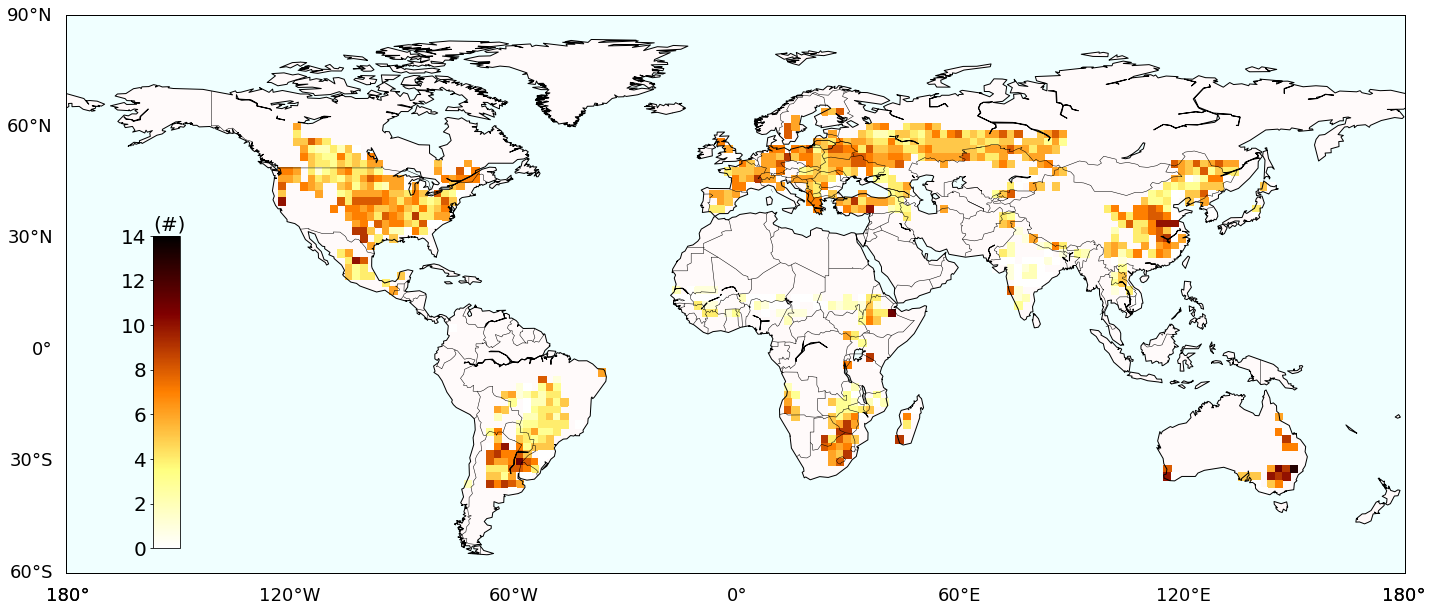

In [13]:
import matplotlib.pyplot as plt    
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import maskoceans
            
#figure shows the spatial pattern of drought frequency
fig=plt.figure(figsize=(24,18))
ax1 = fig.add_subplot(111)
m = Basemap(llcrnrlon=-180,llcrnrlat=-60,urcrnrlon=180,urcrnrlat=90, epsg=4326)
#m.drawmapboundary(fill_color='lightcyan')
#m.fillcontinents(color='snow',lake_color='lightcyan')
m.drawmapboundary(fill_color='azure')
m.fillcontinents(color='snow',lake_color='azure')
tmask5=maskoceans(lon3s[0:65,0:175],lat3s[0:65,0:175],esi_ad1[:,:],inlands=True)
shade=m.pcolor(lon3s[0:65,0:175],lat3s[0:65,0:175],tmask5,vmin=0,vmax=14,cmap=plt.cm.afmhot_r)
cax = ax1.inset_axes([0.065, 0.045, 0.02, 0.56])#35% from the left edge, 14% from the bottom, width 30% of ax2, 0.03 height/weight of the colorbar
cbar = fig.colorbar(shade, cax=cax, ticklocation='left',orientation='vertical')
#cbar.set_ticks([0,20,40,60,80])  # Set the tick positions
#cbar.set_ticklabels([ '0', '20','40','60','80'])  # Set the tick labels
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title('(#)', fontsize=20, loc='left')
m.drawcoastlines()
m.drawcountries()
# Draw longitude and latitude ticks without grid lines
m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color='none', fontsize=18)
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color='none', fontsize=18)

In [14]:
#interannula nirv_max
nirvf_maxa=np.zeros((20,66,176))*np.nan#full 2002-2021(yr+1 case to cut off 1 year)
for yr in range(20):
    for y in range(66):
        for x in range(176):
            sog_na=imog_nac2[0,y,x]
            eog_na=imog_nac2[1,y,x]
            if np.isnan(sog_na)==False and np.isnan(eog_na)==False and imai_2degf[y,x]>=2:
                sogr_na=int(round(sog_na)/5.)#if %5==0, then need to -1
                eogr_na=int(round(eog_na)/5.)
                if sogr_na%5==0:
                    sogr_na=sogr_na-1
                if eogr_na%5==0:
                    eogr_na=eogr_na-1
                if sogr_na<eogr_na:
                    nirl=nirvf_m5[yr,sogr_na:eogr_na+1,y,x]
                    #nirvf_mean[y,x]=np.nanmean(nirl)
                    nirvf_maxa[yr,y,x]=np.nanmax(nirl)
                if sogr_na>eogr_na:
                    nirl=np.append(nirvf_m5[yr,sogr_na::,y,x],nirvf_m5[yr+1,0:eogr_na+1,y,x])
                    #nirvf_mean[y,x]=np.nanmean(nirl)
                    nirvf_maxa[yr,y,x]=np.nanmax(nirl)

C:\Users\jiang\AppData\Local\Temp\ipykernel_29288\2280741499.py:18: RuntimeWarning: All-NaN slice encountered
  nirvf_maxa[yr,y,x]=np.nanmax(nirl)
C:\Users\jiang\AppData\Local\Temp\ipykernel_29288\2280741499.py:22: RuntimeWarning: All-NaN slice encountered
  nirvf_maxa[yr,y,x]=np.nanmax(nirl)


In [17]:
#delete NAN values
nirvf_maxa2=np.zeros((16,65,175))*np.nan#04 [yr+2]2003-2019
for yr in range(16):
    for y in range(65):
        for x in range(175):
            if np.isnan(fra_vr2[y,x])==False:
                nirvf_maxa2[yr,y,x]=nirvf_maxa[yr+1,y,x]

In [15]:
#AIRS: 2003-2019
fra_ca5m=np.load('/change to your path/gnip_airs_fra65_A1_new.npy',allow_pickle=True)
fra_vr=np.zeros((66,176))*np.nan
for y in range(66):
    for x in range(176):
        if np.isnan(glos_rfs2[y,x])==False and np.isnan(glos_rep2[y,x])==False:
            d1=int(glos_rfs2[y,x]-1)
            d2=int(glos_rep2[y,x]-1)
            if d1<d2:
                fra_vr[y,x]=np.nanmean(fra_ca5m[d1:d2,y,x])
            if d1>d2:
                fracom4=np.append(fra_ca5m[d1:73,y,x],fra_ca5m[0:d2,y,x])
                fra_vr[y,x]=np.nanmean(fracom4)

In [16]:
fra_vr2=np.zeros((66,176))*np.nan
for y in range(66):
    for x in range(176):
        if np.isnan(fra_vr[y,x])==False:
            fra_vr2[y,x]=fra_vr[y,x]

In [18]:
#ESI value averaged during the vegetative & reproductive stages
esi_vr=np.zeros((16,65,175))*np.nan
for y in range(65):
    for x in range(175):
        if np.isnan(glos_rfs2[y,x])==False and np.isnan(glos_rep2[y,x])==False and imai_2degf[y,x]>=2 and np.isnan(nirvf_mean[y,x])==False:
            d1=int(round(glos_rfs2[y,x]*5/7))
            if round(glos_rfs2[y,x]*5)%7==0:
                d1=d1-1
            d2=int(round(glos_veg2[y,x]*5/7))
            if round(glos_veg2[y,x]*5)%7==0:
                d2=d2-1
            d3=int(round(glos_rep2[y,x]*5/7))
            if round(glos_rep2[y,x]*5)%7==0:
                d2=d2-1
            for yr in range(16):
                eli=esi_c[yr,:,y,x]
                if np.count_nonzero(np.isnan(eli))!=52:
                    if d1<d3 and d1>0:
                        eli2=eli[d1:d3+1]
                    if d1<0:
                        eli2=np.append(esi_c[yr-1,51+d1:52,y,x],eli[0:d3])
                    if d1>d3:
                        eli2=np.append(eli[d1:52],esi_c[yr+1,0:d3+1,y,x])
                    esi_vr[yr,y,x]=np.nanmean(eli2)

C:\Users\jiang\AppData\Local\Temp\ipykernel_29288\2643651015.py:24: RuntimeWarning: Mean of empty slice
  esi_vr[yr,y,x]=np.nanmean(eli2)


In [19]:
#detrend (save the potential trend in this version)
from sklearn import preprocessing

#SSA function
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

#new version to keep both
def SSA_sip(X, N, L):
    K = N - L + 1
    fx = np.column_stack([X[i:i+L] for i in range(K)])
    
    d = np.linalg.matrix_rank(fx)
    U, Sigma, V = np.linalg.svd(fx)
    V = V.T

    X_elem = np.array([Sigma[i] * np.outer(U[:, i], V[:, i]) for i in range(d)])
    
    # Reconstruct the first PC as the "trend"
    F_trend = X_to_TS(X_elem[0])

    # Everything else as "residual"
    F_residual = X_to_TS(X_elem[1:].sum(axis=0))
    
    return F_trend, F_residual

In [20]:
#sensitivity & changes in NIRv_max
#two detrend methods fowwing the Methods section
nir_ptn=np.zeros((16,65,175))*np.nan#the residual part
nir_ptn2=np.zeros((16,65,175))*np.nan#ratio of original time series aginst the trend 
for y in range(65):
    for x in range(175):
        l1=nirvf_maxa2[:,y,x]
        if np.count_nonzero(np.isnan(l1))<=7:#at least 3 values
            l2=nirvf_maxa2[:,y,x]
            if np.count_nonzero(np.isnan(l2))==0:
                l3=nirvf_maxa2[:,y,x]
                trend, residual=SSA_sip(l3,16,7)
                nir_ptn[:,y,x]=preprocessing.scale(residual)
                nir_ptn2[:,y,x]=l3/trend-1
            else: 
                x1=np.arange(2002,2022)
                lori=nirvf_maxa[:,y,x]
                interp_1n=interp1d(np.delete(x1,np.where(np.isnan(lori))),np.delete(lori,np.where(np.isnan(lori))),kind='nearest',bounds_error=False,fill_value='extrapolate')
                lori2=interp_1n(x1)
                l3=lori2[1:17]
                trend, residual=SSA_sip(l3,16,7)
                nir_ptn[:,y,x]=preprocessing.scale(residual)
                nir_ptn2[:,y,x]=l3/trend-1

In [21]:
#linear regression to quantify drought sensitivity
nevr=np.zeros((2,65,175))*np.nan
for y in range(65):
    for x in range(175):
        if np.count_nonzero(np.isnan(nir_ptn[:,y,x]))<=13 and np.count_nonzero(np.isnan(esi_vr[:,y,x]))<=13:  
            e1=np.delete(esi_vr[:,y,x],np.where(np.isnan(nir_ptn[:,y,x])))
            n1=np.delete(nir_ptn[:,y,x],np.where(np.isnan(nir_ptn[:,y,x])))
            e12=np.delete(e1,np.where(np.isnan(e1)))
            n12=np.delete(n1,np.where(np.isnan(e1)))
            c=stats.linregress(e12,n12)
            nevr[0,y,x]=c[0]
            nevr[1,y,x]=c[3]

In [22]:
#statsitic + f: aggregated to 7 f levels
ec_bin2=[[] for t in range(7)]
ecm_bin2=np.zeros(7)*np.nan
ec2_bin2=np.zeros(7)*np.nan
ec7_bin2=np.zeros(7)*np.nan
fra_bin2=[[] for t in range(7)]
for i in range(1,8):
    for y in range(65):
        for x in range(175):
            if fra_vr2[y,x]*100<=i*12 and fra_vr2[y,x]*100>(i-1)*12 and np.isnan(nirvf_mean[y,x])==False and np.isnan(nevr[0,y,x])==False:
                ec_bin2[i-1]=np.append(ec_bin2[i-1],nevr[0,y,x])
                fra_bin2[i-1]=np.append(fra_bin2[i-1],fra_vr2[y,x])
    ecm_bin2[i-1]=np.nanmean(ec_bin2[i-1])
    ec2_bin2[i-1]=np.nanpercentile(ec_bin2[i-1],25)
    ec7_bin2[i-1]=np.nanpercentile(ec_bin2[i-1],75)

{-180: ([<matplotlib.lines.Line2D at 0x1a99508c0a0>],
  [Text(-179.64, -63.6, '180°'), Text(179.64, -63.6, '180°')]),
 -120: ([<matplotlib.lines.Line2D at 0x1a9950961c0>],
  [Text(-119.88, -63.6, '120°W')]),
 -60: ([<matplotlib.lines.Line2D at 0x1a995096490>],
  [Text(-59.760000000000005, -63.6, '60°W')]),
 0: ([<matplotlib.lines.Line2D at 0x1a995096760>],
  [Text(0.3599999999999852, -63.6, '0°')]),
 60: ([<matplotlib.lines.Line2D at 0x1a995096a30>],
  [Text(60.120000000000005, -63.6, '60°E')]),
 120: ([<matplotlib.lines.Line2D at 0x1a995096d00>],
  [Text(120.24000000000001, -63.6, '120°E')]),
 180: ([<matplotlib.lines.Line2D at 0x1a9950a3040>],
  [Text(-179.64, -63.6, '180°'), Text(179.64, -63.6, '180°')])}

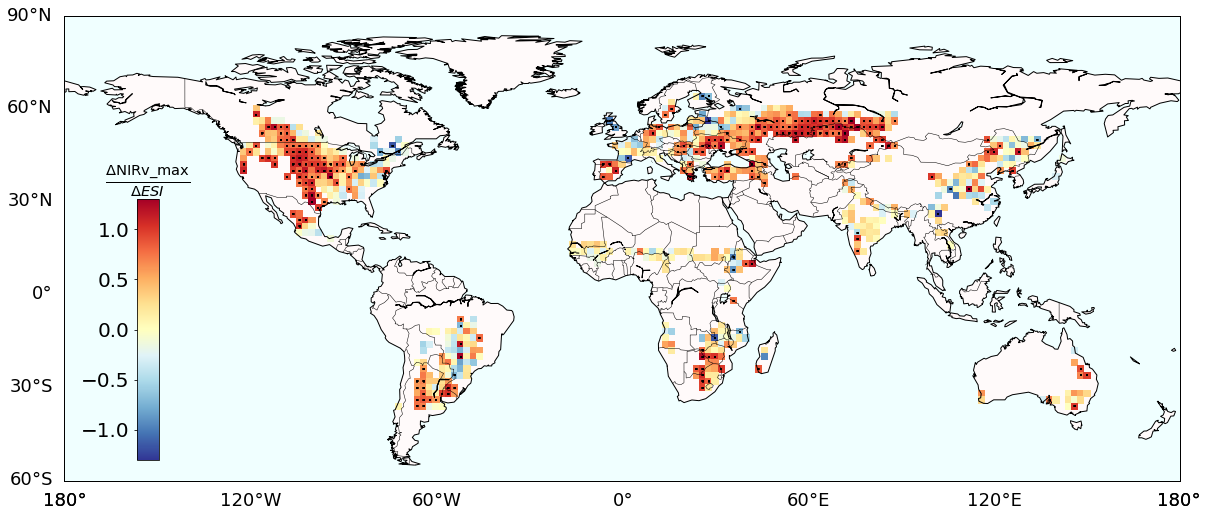

In [23]:
#Fig. 5a
fig=plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(111)
m = Basemap(llcrnrlon=-180,llcrnrlat=-60,urcrnrlon=180,urcrnrlat=90, epsg=4326)
#m.drawmapboundary(fill_color='lightcyan')
#m.fillcontinents(color='snow',lake_color='lightcyan')
m.drawmapboundary(fill_color='azure')
m.fillcontinents(color='snow',lake_color='azure')
tmask5=maskoceans(lon3s[0:65,0:175],lat3s[0:65,0:175],nevr[0,:,:],inlands=True)
shade=m.pcolor(lon3s[0:65,0:175],lat3s[0:65,0:175],tmask5,vmin=-1.3,vmax=1.3,cmap=plt.cm.RdYlBu_r)
cax = ax1.inset_axes([0.065, 0.045, 0.02, 0.56])#35% from the left edge, 14% from the bottom, width 30% of ax2, 0.03 height/weight of the colorbar
cbar = fig.colorbar(shade, cax=cax, ticklocation='left',orientation='vertical')
#cbar.set_ticks([0,20,40,60,80])  # Set the tick positions
#cbar.set_ticklabels([ '0', '20','40','60','80'])  # Set the tick labels
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_title(r'$\frac{\Delta \mathrm{NIRv\_max}}{\Delta ESI}$', fontsize=21, loc='center')
m.drawcoastlines()
m.drawcountries()
sts1=np.zeros_like(nevr[1,:,:])
stsi=np.where(nevr[1,:,:]<=0.1)
sts1[stsi]=5
#shade=m.contourf(lons,lats,ts*10,ddlevels,cmap=mycmap)
m.scatter(lon3s[0:65,0:175],lat3s[0:65,0:175],s=sts1[:,:],c='k',marker='+')
# Draw longitude and latitude ticks without grid lines
m.drawparallels(range(-90, 91, 30), labels=[True, False, False, False], color='none', fontsize=18)
m.drawmeridians(range(-180, 181, 60), labels=[False, False, False, True], color='none', fontsize=18)


In [24]:
#now compare croplands with f<36% and f>=36%
di_bin1=[[] for t in range(4)]
dim_bin1=np.zeros(4)*np.nan
di_bin2=[[] for t in range(4)]
dim_bin2=np.zeros(4)*np.nan
for yr in range(16):
    for y in range(65):
        for x in range(175):
            if np.isnan(nir_ptn2[yr,y,x])==False and np.isnan(esi_id1[yr,y,x])==False:
                if fra_vr2[y,x]<0.36:
                    if esi_id1[yr,y,x]>=-0.5:
                        di_bin1[3]=np.append(di_bin1[3],nir_ptn2[yr,y,x])
                    if esi_id1[yr,y,x]<-0.5 and esi_id1[yr,y,x]>=-1.0:
                        di_bin1[2]=np.append(di_bin1[2],nir_ptn2[yr,y,x])
                    if esi_id1[yr,y,x]<-1.0 and esi_id1[yr,y,x]>=-1.5:
                        di_bin1[1]=np.append(di_bin1[1],nir_ptn2[yr,y,x])
                    if esi_id1[yr,y,x]<-1.5:
                        di_bin1[0]=np.append(di_bin1[0],nir_ptn2[yr,y,x])
                        
                if fra_vr2[y,x]>=0.36:
                    if esi_id1[yr,y,x]>=-0.5:
                        di_bin2[3]=np.append(di_bin2[3],nir_ptn2[yr,y,x])
                    if esi_id1[yr,y,x]<-0.5 and esi_id1[yr,y,x]>=-1.0:
                        di_bin2[2]=np.append(di_bin2[2],nir_ptn2[yr,y,x])
                    if esi_id1[yr,y,x]<-1.0 and esi_id1[yr,y,x]>=-1.5:
                        di_bin2[1]=np.append(di_bin2[1],nir_ptn2[yr,y,x])
                    if esi_id1[yr,y,x]<-1.5:
                        di_bin2[0]=np.append(di_bin2[0],nir_ptn2[yr,y,x])
                        
for t in range(4):
    dim_bin1[t]=np.nanmean(di_bin1[t])
    dim_bin2[t]=np.nanmean(di_bin2[t])

cb1=np.zeros((2,3))*np.nan
cb2=np.zeros((2,3))*np.nan
for i in range(3):
    data_tuple = (di_bin1[i],)
    res=stats.bootstrap(data_tuple,statistic=np.mean, n_resamples=1000, confidence_level=0.95,method='BCa' )
    ci_low1, ci_high1 = res.confidence_interval
    cb1[0,i]=ci_low1
    cb1[1,i]=ci_high1
    
    data_tuple = (di_bin2[i],)
    res=stats.bootstrap(data_tuple,statistic=np.mean, n_resamples=1000, confidence_level=0.95,method='BCa' )
    ci_low2, ci_high2 = res.confidence_interval
    cb2[0,i]=ci_low2
    cb2[1,i]=ci_high2

C:\Users\jiang\AppData\Local\Temp\ipykernel_29288\2006517179.py:31: RuntimeWarning: Mean of empty slice
  dim_bin1[t]=np.nanmean(di_bin1[t])
C:\Users\jiang\AppData\Local\Temp\ipykernel_29288\2006517179.py:32: RuntimeWarning: Mean of empty slice
  dim_bin2[t]=np.nanmean(di_bin2[t])


In [25]:
#add t test
wdt=np.zeros(3)
for i in range(3):
    t_stat, p_value = stats.ttest_ind(di_bin1[i], di_bin2[i], equal_var=False)
    wdt[i]=p_value

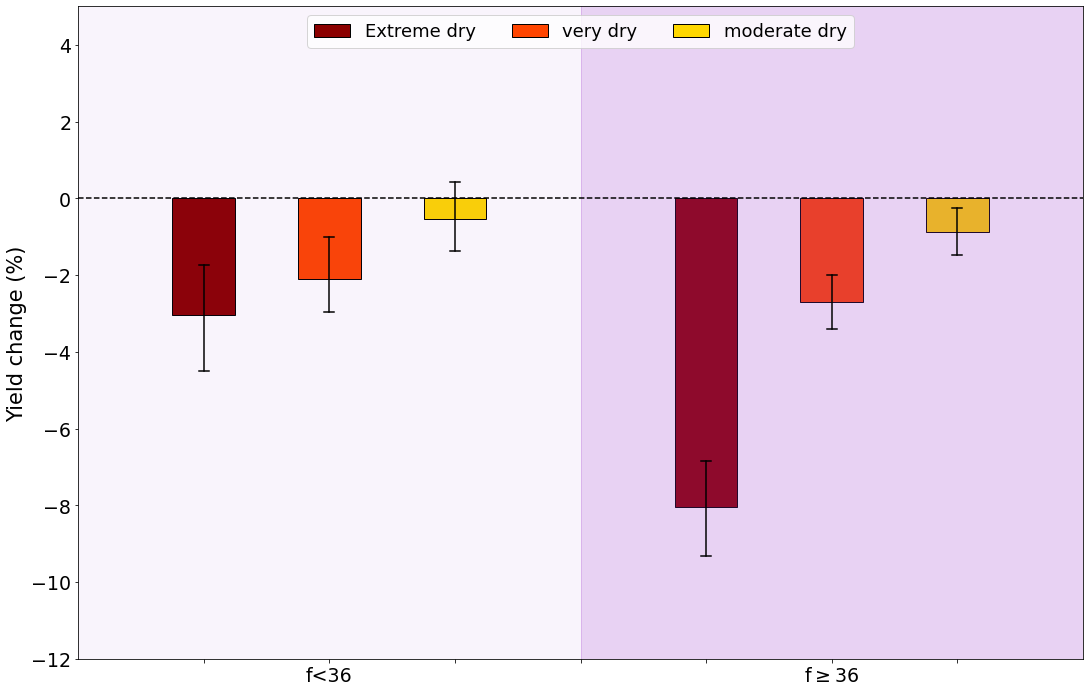

In [26]:
#Fig. 5c
fig=plt.figure(figsize=(18,12))
ax3 = fig.add_subplot(111)
width=0.5
horizontal_line_width=0.08
p1=ax3.bar([1,5],[dim_bin1[0]*100,dim_bin2[0]*100],width,color='darkred',edgecolor='k') 
p2=ax3.bar([2,6],[dim_bin1[1]*100,dim_bin2[1]*100],width,color='orangered',edgecolor='k') 
p3=ax3.bar([3,7],[dim_bin1[2]*100,dim_bin2[2]*100],width,color='gold',edgecolor='k') 
ax3.plot(np.arange(9),np.zeros(9),'k--')
ax3.tick_params(labelsize=19)
ax3.legend((p1[0],p2[0],p3[0]),('Extreme dry','very dry','moderate dry'),loc='upper center',ncol=3,prop={'size': 18})
ax3.set_xlim(0,8)
ax3.set_ylim(-12,5)
#small loop
for i in range(1,4):
    left = np.arange(4)[i]  - horizontal_line_width / 2
    top = cb1[0,i-1]*100
    right =  np.arange(4)[i]  + horizontal_line_width / 2
    bottom = cb1[1,i-1]*100
    xi=np.arange(4)[i]
    plt.plot([xi, xi], [top, bottom], color='k',linewidth=1.5)
    plt.plot([left, right], [top, top], color='k',linewidth=1.5)
    plt.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)
    
for i in range(1,4):
    left = np.arange(4,8)[i]  - horizontal_line_width / 2
    top = cb2[0,i-1]*100
    right =  np.arange(4,8)[i]  + horizontal_line_width / 2
    bottom = cb2[1,i-1]*100
    xi=np.arange(4,8)[i]
    plt.plot([xi, xi], [top, bottom], color='k',linewidth=1.5)
    plt.plot([left, right], [top, top], color='k',linewidth=1.5)
    plt.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)
ax3.set_xticks([1,2,3,4,5,6,7])
ax3.set_xticklabels(['','f<36','','','','f'+r'$\geq 36$',''])
ax3.set_ylabel('Yield change (%)',fontsize=21)
#add background fill
ax3.fill_between(np.linspace(-0.5,4,10),np.ones(10)*-12,np.ones(10)*35,color='darkorchid',alpha=0.05)
ax3.fill_between(np.linspace(4,8.5,10),np.ones(10)*-12,np.ones(10)*35,color='darkorchid',alpha=0.22)